# **_Business Understanding_**


### ** The Data Set **

The Data Set used is "default of credit card clients" from UCI, provided by I-Cheng Yeh with Chung Hua University and Tamkang University in Taiwan.  The purpose of the data set is to accurately predict the probablity of default for credit card customers in Taiwan.

### ** The Purpose of the Data Set **

The reason the creators of the data wanted to predict default rates was not given.  Business applications of predicting an overall default rate could include capcacity planning and financial reporting.  However, the ability to predict the likelihood that a given customer will default can also be an important aspect of managing the profitability of a credit card business.  Projecting the likelihood of default for a given customer can be used to:

    1. Determine the collection strategy if a customer misses a payment, and 
    2. Determine the appropriate credit limit for that customer.

It should be noted that an inaccurate projection in either direction when used to determine how a customer will be treated can adversely impact profitability.  If the risk is overestimated, collection efforts may be too intense thereby alienating customers and unnecessarily constraining credit lines.  Restricing credit lines too much may inhibit customers' ability and willingness to use the product.  If the risk is underestimated, the bank will incur higher losses than it might otherwise.  We expect that a more acceptable bias would be to overestimate the likelihood of default rather than underestimate it.

### ** Measuring the Succsess of an Algorithm **

We will set aside a portion of the data for validation (the test set), and use Logistic Regression on the remaining training set.

The effectiveness of the model in predicting an overall default rate will be measured by its performance when applied to the hold-out set.  If the actual results are within 10% of the estimate, we will deem it to be successful.  We will also use the AUC against the test set.  Judgmentally, we will consider an AUC of 80% or more acceptable.

To test the effectiveness of the model for use in determining the course of action with respect to a specific customer we will look for specificity and sensitivity rates at certain probabilities of default.  In order to determine whether a "lighter" collection strategy should be used, we will look for those probabilities where the sensitivity (true positive rate) is greater than 90%. In order to determine that a request to increase credit will be declined, we will look for those probabilities where the specificity is 90% or more. 


In [ ]:
# Paul's Random Notes we might want to be aware of or mention:

    1. Do we think Attribute 'PAY_0' is really 'PAY_1'?
    2. We don't know the definition of "Default"
    3. We are missing certain infromation that we believe would be important in predicting default
        (based on industry knowledge)
        - Age of Account
        - Total Number of Payments Made
        - Indication of whether or not customer is paying their Other obligations.
    
    
### Variables we might want to Create to Look At:
    1. Line Utilization (Billed Amount/Limit)
    2. Growth in Billed Amount:  Most Recent/Average, 
                                 Whether or not most recent is the largest, or 
                                growth from ave of first three months.
    3.Number of Months Delinquent (1-8 and any)
    4. Is first Delinquency in the last month or two?
    5. % of Billed Amount Paid.
    



#  **_Just Entering the Data and Making Sure it's there_**

In [2]:
# Importing Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# Readung in the data file
df = pd.read_csv('Data/CreditCardDefaults.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,Unnamed: 25,Unnamed: 26
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,NaN,6636.0
1,2,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,NaN,NaN
2,3,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,NaN,NaN
3,4,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,NaN,NaN
4,5,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
ID             30000 non-null int64
LIMIT_BAL      30000 non-null int64
SEX            30000 non-null int64
EDUCATION      30000 non-null int64
MARRIAGE       30000 non-null int64
AGE            30000 non-null int64
PAY_0          30000 non-null int64
PAY_2          30000 non-null int64
PAY_3          30000 non-null int64
PAY_4          30000 non-null int64
PAY_5          30000 non-null int64
PAY_6          30000 non-null int64
BILL_AMT1      30000 non-null int64
BILL_AMT2      30000 non-null int64
BILL_AMT3      30000 non-null int64
BILL_AMT4      30000 non-null int64
BILL_AMT5      30000 non-null int64
BILL_AMT6      30000 non-null int64
PAY_AMT1       30000 non-null int64
PAY_AMT2       30000 non-null int64
PAY_AMT3       30000 non-null int64
PAY_AMT4       30000 non-null int64
PAY_AMT5       30000 non-null int64
PAY_AMT6       30000 non-null int64
default        30000 non-nu

# **_Exploring Joint Attributes_**

### Autocorrelation

Three of the variables in our data set are Time Series. (Amount Billed, Payment Amount, and Pay which we are calling "Payment Delinquency Status").  We explored the potential for Autocorrelation within these series by reviewing scatterplots and correlation matrices.  These indicate that autocorrelation is likely to be an issue for billed amounts, and perhaps Payment Status.  We are aware that using correlation on categorical variables in generally nonsensical, but in this case, we feel that it is at least worth looking at.  [I WILL EXPLORE THIS IN TABLEAU]  While we should still test for autocorrelation in the Payment Amount variable in the modelling phase, we are less concerned about this based on correlation matrix.

        1.  Payments:  Based on visual inspection of a scatterplot matrix and on a correlation matrix, we DO NOT expect 
        serial correlation to be an issue with this variable.
        
        2.  Billed Amounts: Based on visual inspection of a scatterplot matrix and on a correlation matrix, we DO expect 
        serial correlation to be an issue with this variable.
        
        3.  Pay (Payment Delinquency Status):  Scatterplots are not helpful because with this data set they do not show
            concentrations of data points.  However, a cross-tabulation indicates that there is meaningful autocorrelation
            with this variable.   Accounts in one delinquency status tend to remain in that status.  A correllation matrix,
            while it should be used carefuly because the PAY variable is ordinal but not continuous, confirms this.
            
Autocorrelations must be explored further and addressed in the modelling phase.
        

### Structural Relationships
                                                         
There are two structural relationships between attributes:
    
        1. The Amount of the Payment is likely related to the Amount Billed. While the correlation between payments and 
        billed amounts is 30%, We should explore transformations for this.  The payment as % of billed amount as a continuous
        variable, or as a categorical variable may add predictive value. 
        
        2. The Amount Billed should be limited by the Credit Limit. The correlations between the credit limit and amount 
        billed range between 28% and 30%.  While these are not excessive they are concerning and the limiting pattern is 
        visible in scatter plots.  These factors and the logical connection between the variables could warrant 
        transformation.  One candidate is the billed amount as a % of the credit limit.

In [3]:
# Creating Lists of Attributes to Analyze 
BillsAndPayments=['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default']
Bills=['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','default']
Payments=['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default']
PayStatus=['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default']
PayStausOnly = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']

### Analyzing Payments

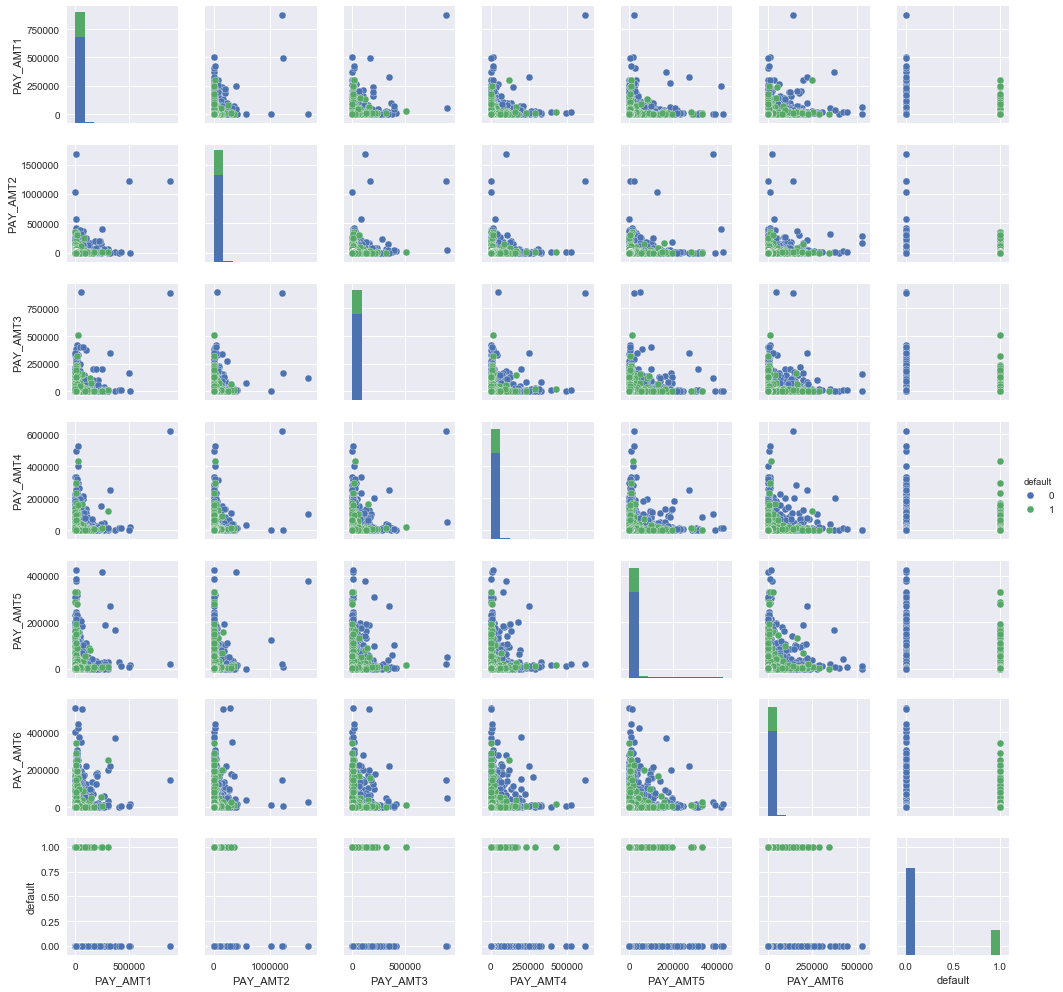

In [4]:
%matplotlib inline
sns.set()
g = sns.pairplot(df[Payments],hue = 'default',size = 2)

In [5]:
df[Payments].corr()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
PAY_AMT1,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735,-0.072929
PAY_AMT2,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634,-0.058579
PAY_AMT3,0.252191,0.244770,1.000000,0.216325,0.159214,0.162740,-0.056250
PAY_AMT4,0.199558,0.180107,0.216325,1.000000,0.151830,0.157834,-0.056827
PAY_AMT5,0.148459,0.180908,0.159214,0.151830,1.000000,0.154896,-0.055124
PAY_AMT6,0.185735,0.157634,0.162740,0.157834,0.154896,1.000000,-0.053183
default,-0.072929,-0.058579,-0.056250,-0.056827,-0.055124,-0.053183,1.000000


### Analyzing serial correlation in Billed Amounts and relationship between Billed Amounts and Credit Limits

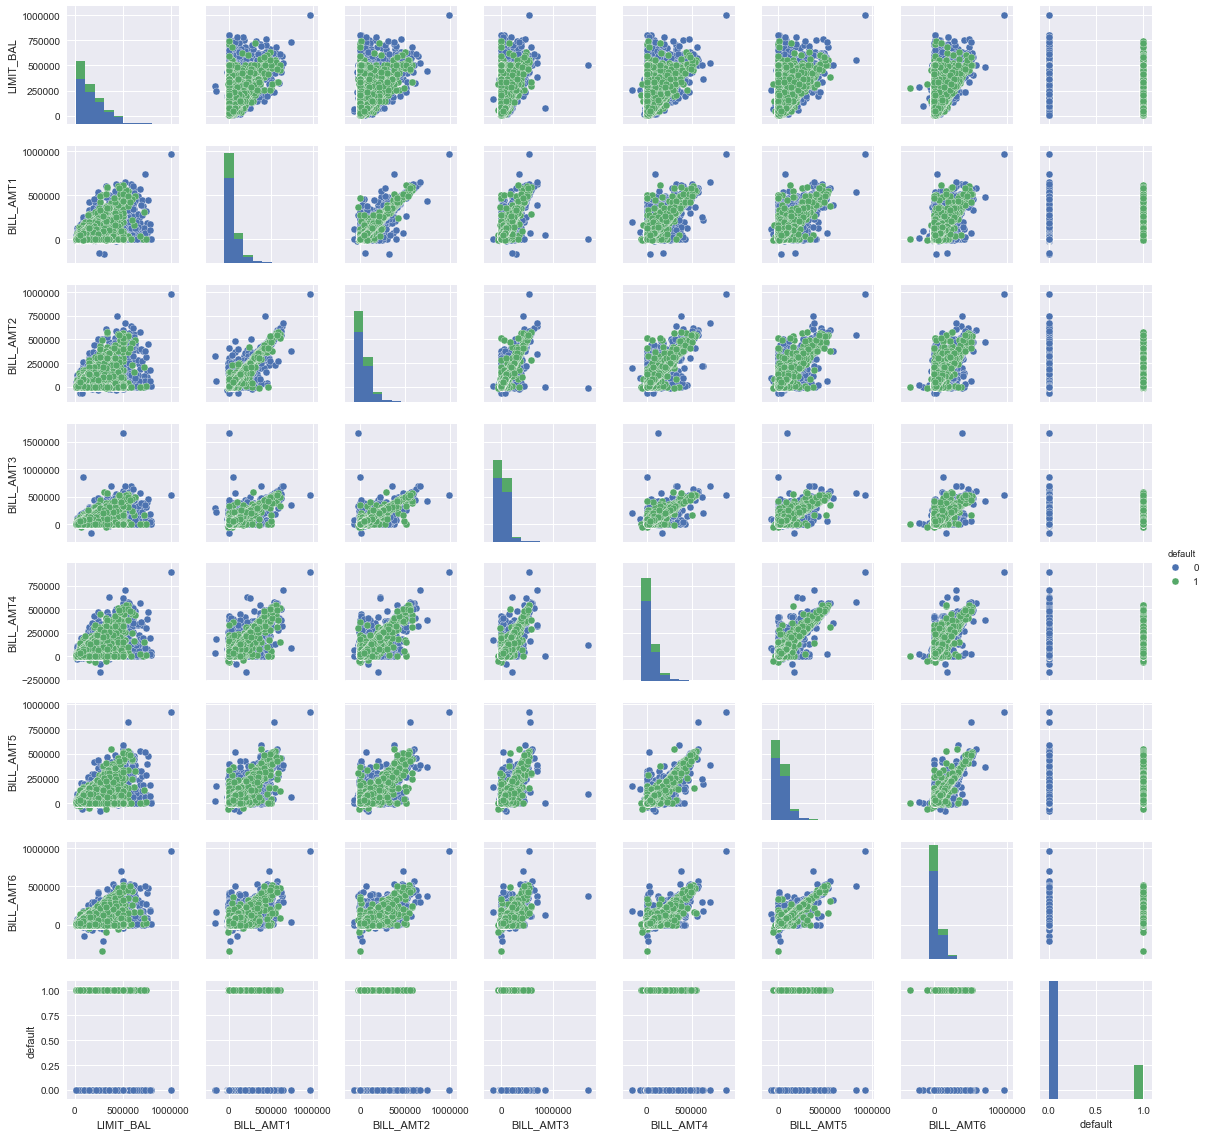

In [6]:
%matplotlib inline
sns.set()
sns.pairplot(df[Bills],hue = 'default',size = 2)

In [7]:
df[Bills].corr()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,default
LIMIT_BAL,1.000000,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,-0.153520
BILL_AMT1,0.285430,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650,-0.019644
BILL_AMT2,0.278314,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594,-0.014193
BILL_AMT3,0.283236,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320,-0.014076
BILL_AMT4,0.293988,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941,-0.010156
BILL_AMT5,0.295562,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197,-0.006760
BILL_AMT6,0.290389,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000,-0.005372
default,-0.153520,-0.019644,-0.014193,-0.014076,-0.010156,-0.006760,-0.005372,1.000000


### Analyzing Pay ("Payment Delinquency Status")

In [8]:
df[PayStatus].corr()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default
PAY_0,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.324794
PAY_2,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.263551
PAY_3,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.235253
PAY_4,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.216614
PAY_5,0.509426,0.622780,0.686775,0.819835,1.000000,0.816900,0.204149
PAY_6,0.474553,0.575501,0.632684,0.716449,0.816900,1.000000,0.186866
default,0.324794,0.263551,0.235253,0.216614,0.204149,0.186866,1.000000


In [4]:
# Creating a cross-tab of counts to check autocerrelation in Payment Status showing the migration from one period to the next.
# The rows are the first period status and the columns are the next period status. 
# This requires re-shaping the data.

# First, create a single column of all Initial time period statuses, regardless of attribute name.
InitialList = ['PAY_6','PAY_5','PAY_4','PAY_3','PAY_2']
dfFirstStatus = df[InitialList]
StatusStacked = pd.DataFrame({'First':dfFirstStatus.stack()})
StatusStacked = StatusStacked.reset_index(drop=True)

# Then, create a single column of all subsequent time period statuses, regardless of attribute name.
NextList = ['PAY_5','PAY_4','PAY_3','PAY_2','PAY_0']
dfNextStatus = df[NextList]
NextStatusStacked = pd.DataFrame({'Next':dfNextStatus.stack()})
NextStatusStacked = NextStatusStacked.reset_index(drop=True)

# Combining the two columns into a single df.
StatusStacked['Next'] = NextStatusStacked['Next']
pd.crosstab(StatusStacked['First'],StatusStacked['Next'])





Next,-2,-1,0,1,2,3,4,5,6,7,8
First,,,,,,,,,,,
-2,17602,1477,1091,1233,253,0,0,0,0,0,0
-1,1904,21915,3476,621,1038,0,0,0,0,0,0
0,4,4106,72148,6,4918,0,0,0,0,0,0
1,0,0,0,34,0,0,0,0,0,0,0
2,10,1306,2814,1676,9460,1031,0,0,0,0,0
3,0,84,92,109,362,176,285,0,0,0,0
4,0,8,8,32,85,29,106,109,0,0,0
5,0,3,3,7,18,7,11,12,50,0,0
6,0,1,1,2,5,1,1,3,4,45,0


In [5]:
df[PayStatus].corr()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default
PAY_0,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.324794
PAY_2,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.263551
PAY_3,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.235253
PAY_4,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.216614
PAY_5,0.509426,0.622780,0.686775,0.819835,1.000000,0.816900,0.204149
PAY_6,0.474553,0.575501,0.632684,0.716449,0.816900,1.000000,0.186866
default,0.324794,0.263551,0.235253,0.216614,0.204149,0.186866,1.000000


# Paul's thoughts on Data Quality

### No values coded as missing, or empty cells in the CSV file provided.

### Field definitions and Naming:

    1. The naming convention of the Payment, Bill and Payment Status fields are that the calendar month of the attribute is 
    given by sequential integers at the end of the name. The PAY_N fields go from PAY_0 to PAY_2.  We are assuming that PAY_0
    is really PAY_1.
    2.  The descriptions of values -2 and 0 in the PAY_N fields are not provided.  Based on visual inspection, a value of -2 
    appears to indicate that no payment is due because the account has a credit balance.  Because a value of -1 means "Paid 
    on time" and a value of 1 means one month late, we are assuming that a value of zero means less than one month late.
    It may be that these are missing values coded as 0.  About half of the data set has a value of 0 for these attributes.
    3.  Values for the Marriage attribute of 0 is undefined.  There are only 54 instances.  We treated these as "Other", 
    which has 323 Instances.
    
### Suspicious values:
    1.  There are only 34 instances where the Pay Status had a value of 1 for two months in a row.  This is highly unusual 
    given the propensity for customers with status values of 1 or 2 to remain in their current payment status for one month. 
    This propensity is seen in the cross-tab in the Joint Attribute section.
    2.  It appears that the first month the value of 1 is used is in PAY_0, with only a few observations prior to that.  
    Therfore, it seems that there is a methodology change part-way through the data series.  We will proceed with caution 
    since the number of observations is small.
    4.  There are instances where the Payment Status implieslate payment, but the amount billed was zero or less.  This seems
    nonsensical.  Thee are 1,769 such cases (out of 150,000 possible payments:  30,000 accounts and 5 months of validatable 
    data) if measured against payment statuses defined as delinquent by the data providers, and 4,702 if we consider Payment
    Status of zero as delinquent.



In [6]:
df[PayStausOnly].apply(pd.value_counts)

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
-2,2759,3782,4085,4348,4546.0,4895.0
-1,5686,6050,5938,5687,5539.0,5740.0
0,14737,15730,15764,16455,16947.0,16286.0
1,3688,28,4,2,NaN,NaN
2,2667,3927,3819,3159,2626.0,2766.0
3,322,326,240,180,178.0,184.0
4,76,99,76,69,84.0,49.0
5,26,25,21,35,17.0,13.0
6,11,12,23,5,4.0,19.0
7,9,20,27,58,58.0,46.0


In [7]:
#Adding Prior Period Balances to table used for evaluating Status accuracy
BillList = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2']
dfPriorBill = df[BillList]

BillStacked = pd.DataFrame({'Billed':dfPriorBill.stack()})
BillStacked = BillStacked.reset_index(drop=True)
StatusStacked['Billed'] = BillStacked['Billed']

In [20]:
## Checking instances of an account coded as delinquent when Billed amount was zero or less,
ProblemCountV_Minus1 = 0
ProblemCountV_Zero = 0

# Checking Delinquency if Status 0 is Delinquent:
for i in np.arange(0,len(StatusStacked)):
    if StatusStacked['Billed'][i] < 1 and StatusStacked['Next'][i]>-1:
        ProblemCountV_Minus1 = ProblemCountV_Minus1 + 1

# Checking Delinquency if Status 1 only is Delinquent:
for i in np.arange(0,len(StatusStacked)):
    if StatusStacked['Billed'][i] < 1 and StatusStacked['Next'][i]>0:
        ProblemCountV_Zero = ProblemCountV_Zero + 1        
        

print("Versus -1: ", ProblemCountV_Minus1,"Versus 0: ", ProblemCountV_Zero)

Versus -1:  4702 Versus 0:  1769


# **_I think everything Below this is Garbage_**

In [ ]:
##payZero = df[['PAY_0','AGE']
df[['PAY_0','AGE']].groupby('PAY_0').count()
df[['PAY_2','AGE']].groupby('PAY_2').count()


In [ ]:
# Paul's Random Notes we might want to be aware of or mention:

    1. Do we think Attribute 'PAY_0' is really 'PAY_1'?
    2. We don't know the definition of "Default"
    3. We are missing certain infromation that we believe would be important in predicting default
        (based on industry knowledge)
        - Age of Account
        - Total Number of Payments Made
        - Indication of whether or not customer is paying their Other obligations.
    
    
### Variables we might want to Create to Look At:
    1. Line Utilization (Billed Amount/Limit)
    2. Growth in Billed Amount:  Most Recent/Average, 
                                 Whether or not most recent is the largest, or 
                                growth from ave of first three months.
    3.Number of Months Delinquent (1-8 and any)
    4. Is first Delinquency in the last month or two?
    5. % of Billed Amount Paid.

In [ ]:
# Scatterplots are ineffective
#%matplotlib inline
#sns.set()
#sns.pairplot(df[PayStatus],hue = 'default',size = 2)

In [ ]:
# Tried Running this seaborn grid, but was just taking too long.

#sns.set(style="white")
#g = sns.PairGrid(df[Payments], hue = 'default', diag_sharey=False)
#g.map_lower(sns.kdeplot,cmap="Blues_d")
#g.map_upper(plt.scatter)
#g.map_diag(sns.kdeplot, lw=3)

In [ ]:
NextList = ['PAY_5','PAY_4','PAY_3','PAY_2','PAY_0']
dfNextStatus = df[NextList]
NextStatusStacked = pd.DataFrame({'Next':dfNextStatus.stack()})
NextStatusStacked = NextStatusStacked.reset_index(drop=True)
NextStatusStacked.head()

print(NextStatusStacked)

StatusStacked['Next'] = NextStatusStacked['Next']
StatusStacked.info()



In [ ]:
## Bill Boxplots by Education

sns.factorplot('EDUCATION','BILL_AMT1','default',df,kind="box", size = 10)
sns.factorplot('EDUCATION','BILL_AMT2','default',df,kind="box", size = 10)
sns.factorplot('EDUCATION','BILL_AMT3','default',df,kind="box", size = 10)
sns.factorplot('EDUCATION','BILL_AMT4','default',df,kind="box", size = 10)
sns.factorplot('EDUCATION','BILL_AMT5','default',df,kind="box", size = 10)
sns.factorplot('EDUCATION','BILL_AMT6','default',df,kind="box", size = 10)

In [ ]:
## Bill Boxplots by Age Group

# Creating Age Buckets
df['Agegroup'] = df['AGE']//10

sns.factorplot('Agegroup','BILL_AMT1','default',df,kind="box", size = 10)
sns.factorplot('Agegroup','BILL_AMT2','default',df,kind="box", size = 10)
sns.factorplot('Agegroup','BILL_AMT3','default',df,kind="box", size = 10)
sns.factorplot('Agegroup','BILL_AMT4','default',df,kind="box", size = 10)
sns.factorplot('Agegroup','BILL_AMT5','default',df,kind="box", size = 10)
sns.factorplot('Agegroup','BILL_AMT6','default',df,kind="box", size = 10)

In [ ]:
## Bill Boxplots by Marital Status

sns.factorplot('MARRIAGE','BILL_AMT1','default',df,kind="box", size = 10)
sns.factorplot('MARRIAGE','BILL_AMT2','default',df,kind="box", size = 10)
sns.factorplot('MARRIAGE','BILL_AMT3','default',df,kind="box", size = 10)
sns.factorplot('MARRIAGE','BILL_AMT4','default',df,kind="box", size = 10)
sns.factorplot('MARRIAGE','BILL_AMT5','default',df,kind="box", size = 10)
sns.factorplot('MARRIAGE','BILL_AMT6','default',df,kind="box", size = 10)

In [ ]:
## Bill Boxplots by Gender

sns.factorplot('SEX','BILL_AMT1','default',df,kind="box", size = 10)
sns.factorplot('SEX','BILL_AMT2','default',df,kind="box", size = 10)
sns.factorplot('SEX','BILL_AMT3','default',df,kind="box", size = 10)
sns.factorplot('SEX','BILL_AMT4','default',df,kind="box", size = 10)
sns.factorplot('SEX','BILL_AMT5','default',df,kind="box", size = 10)
sns.factorplot('SEX','BILL_AMT6','default',df,kind="box", size = 10)

In [ ]:
#Correlation between Payment amount and the prior month Billed Ammount.
Pay1CorrWithLaggedBill = df['PAY_AMT1'].corr(df['BILL_AMT2'])
Pay2CorrWithLaggedBill = df['PAY_AMT2'].corr(df['BILL_AMT3'])
Pay3CorrWithLaggedBill = df['PAY_AMT3'].corr(df['BILL_AMT4'])
Pay4CorrWithLaggedBill = df['PAY_AMT4'].corr(df['BILL_AMT5'])
Pay5CorrWithLaggedBill = df['PAY_AMT5'].corr(df['BILL_AMT6'])

print(Pay1CorrWithLaggedBill,Pay2CorrWithLaggedBill,Pay3CorrWithLaggedBill,Pay4CorrWithLaggedBill,Pay5CorrWithLaggedBill)

In [ ]:
# Cross Tab for categorical variables

def pcntile25(v):
    return np.percentile(v, 25)

def pcntile75(v):
    return np.percentile(v, 75)
    
pd.pivot_table(df,index = ['MARRIAGE'],values = ["PAY_AMT1"], aggfunc=[len, np.mean, pcntile25, np.median, pcntile75])


In [ ]:
pd.pivot_table(df,index = ['SEX'],values = ["PAY_AMT1"], aggfunc=[len, np.mean, pcntile25, np.median, pcntile75])

In [ ]:
df.head()

# Creating New Variables:

    1. Billed amount as % of Credit Limit:  Intuitively we thought this would add value, but visualization is not encouraging.

In [ ]:
#Creating New Variables - Billed amount as % of Credit Limit
BillPctLimit=df['BILL_AMT1']/df['LIMIT_BAL']
#LogBillPctLimit = np.log((df['BILL_AMT1']+1)/(df['LIMIT_BAL']+1))
df = df.assign(BillPctLimit=BillPctLimit.values)
#df = df.assign(LogBillPctLimit=LogBillPctLimit.values)

VizBillPctLimit = ['BILL_AMT1','BillPctLimit','default']
%matplotlib inline
#sns.set(rc={"font.size":35,"axes.titlesize":35,"axes.labelsize":35})
sns.set()
sns.pairplot(df[VizBillPctLimit],hue = 'default',size = 3)


#print(df['BillPctLimit'])
#print(df['BILL_AMT1']/df['LIMIT_BAL'])

In [ ]:
Pmt1PctBal = df['PAY_AMT1']/(df['BILL_AMT1']+.001)
Pmt2PctBal = df['PAY_AMT2']/(df['BILL_AMT2']+.001)
Pmt3PctBal = df['PAY_AMT3']/(df['BILL_AMT3']+.001)
Pmt4PctBal = df['PAY_AMT4']/(df['BILL_AMT4']+.001)
Pmt5PctBal = df['PAY_AMT5']/(df['BILL_AMT5']+.001)
Pmt6PctBal = df['PAY_AMT6']/(df['BILL_AMT6']+.001)

df = df.assign(Pmt1PctBal=Pmt1PctBal.values)
df = df.assign(Pmt2PctBal=Pmt2PctBal.values)
df = df.assign(Pmt3PctBal=Pmt3PctBal.values)
df = df.assign(Pmt4PctBal=Pmt4PctBal.values)
df = df.assign(Pmt5PctBal=Pmt5PctBal.values)
df = df.assign(Pmt6PctBal=Pmt6PctBal.values)

PmtPctBal = ['Pmt1PctBal','Pmt2PctBal','Pmt3PctBal','Pmt4PctBal','Pmt5PctBal','Pmt6PctBal','default']

%matplotlib inline
sns.set()
sns.pairplot(df[PmtPctBal],hue = 'default',size = 3)


In [ ]:
TotalPmtPctBal = (df['PAY_AMT1']+df['PAY_AMT2']+df['PAY_AMT3']+df['PAY_AMT4']+df['PAY_AMT5']+df['PAY_AMT6'])/(df['BILL_AMT1']+df['BILL_AMT2']+df['BILL_AMT3']+df['BILL_AMT4']+df['BILL_AMT4']+df['BILL_AMT6']+1)

df = df.assign(TotalPmtPctBal=TotalPmtPctBal.values)
                                     
%matplotlib inline
sns.set()
sns.pairplot(df[['TotalPmtPctBal','default']],hue = 'default',size = 3)                                                    
                                                    

In [ ]:
pd.pivot_table(df,index = ['default'],values = ["TotalPmtPctBal"], aggfunc=[len, np.mean,np.min, pcntile25, np.median, pcntile75,np.max])

In [ ]:
sns.set()
#sns.factorplot('TotalPmtPctBal','default',df,kind="box", size = 10)

#sns.boxplot(x=df["TotalPmtPctBal"])

sns.distplot(int(float((df["TotalPmtPctBal"]*100)//1)))

In [ ]:
garb = df['TotalPmtPctBal']*100//1

df = df.assign(garb=garb.values)
garbint = df['garb'].astype(np.int64)
df = df.assign(garbint=garbint.values)
#df['garbint1']= np.where(df[garbint]>1000,1000,df[garbint]).tolist()
#df['garbint']= df[garbint].apply(lambda x: [y if y < 300 else 300 for y in x])
df.info()